In [1]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import keras

In [2]:
# using pytorch as backend for keras
os.environ['KERAS_BACKEND'] = 'torch'

In [3]:
# path to the dataset (i'm working on google colab and I uploaded the dataset in myDrive)

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
path = "/content/drive/MyDrive/brain_tumor/"

Mounted at /content/drive/


In [4]:
# path to the train and train datasets
train_dir = "/content/drive/MyDrive/brain_tumor/Training/"
test_dir = "/content/drive/MyDrive/brain_tumor/Testing/"


# The transformations I will apply to the train and test data

# For the train : I resize the images to 224x224 because the resnet50 Model was trained on 224x224 images and apply random crop for data augmentation
# I also added random flips and rotations to the images to add diversity and prevent overfitting
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Transformations on the test set
# Resize the shorter side to 256, then take a center crop of 224x224 for consistent evaluation
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
# Loading the training dataset and create a DataLoader
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

# Loading the test dataset and create a DataLoader
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [6]:
# Verification
train_images, train_labels = next(iter(train_loader))
print("Train batch:", train_images.shape, train_labels.shape)

test_images, test_labels = next(iter(test_loader))
print("Test batch:", test_images.shape, test_labels.shape)

Train batch: torch.Size([64, 3, 224, 224]) torch.Size([64])
Test batch: torch.Size([64, 3, 224, 224]) torch.Size([64])


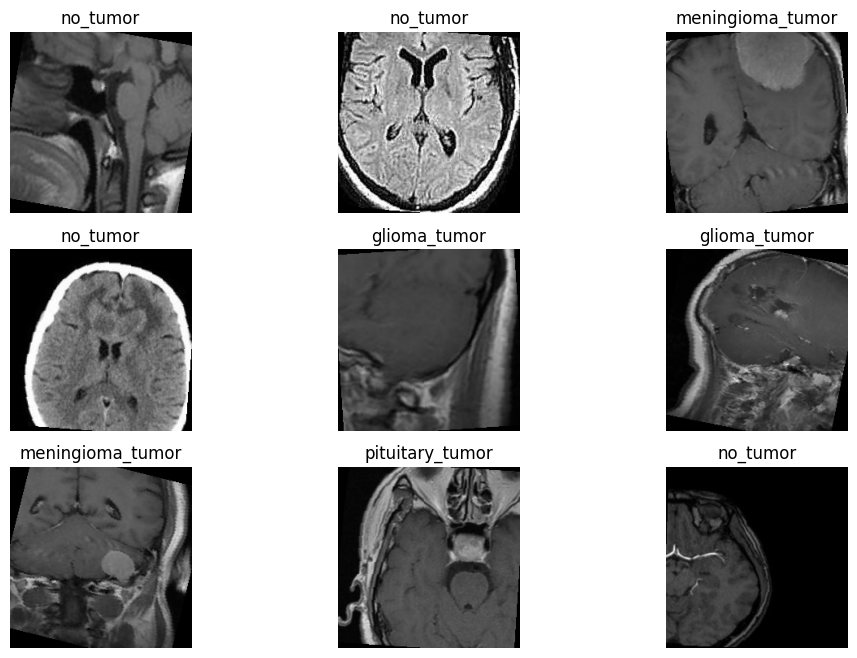

In [7]:
# labels
labels_map = {0: "glioma_tumor",
              1: "meningioma_tumor",
    	      2: "no_tumor",
    	      3: "pituitary_tumor",
}

figure = plt.figure(figsize=(12, 8))
cols, rows = 3, 3

for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    img = img * std + mean  # Denormalisation of the image


    plt.imshow(img.permute(1, 2, 0))

plt.show()




In [8]:
# Setting the device I'll use  for computing

device = (
    "cuda" if torch.cuda.is_available() # j'utilise gpu cuda pour l'entrainement si c'est dispo
    else "mps"
    if torch.backends.mps.is_available() # gpu mps
    else "cpu" # sinon cpu
)
print(f"Using {device} device")

Using cuda device


In [9]:
# Load the pretrained microsoft/resnet-50 model from torchvision
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Modify the last fully connected layer to match the number of tumor classes (4 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 4)   # 4 classes
)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [10]:
# The training loop

epochs = 5

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()  # Setting the model to Training Mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # reset the gradients
        outputs = model(inputs)  # forward
        loss = criterion(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step() # updating the weights

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1) # Get predicted class
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # --- TEST ---
    model.eval()  # Setting the model to Evaluation Mode
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)  # Get predicted class
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / test_total
    test_accuracy = 100. * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Loss and Accuracy after each epoch
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
    print("-" * 50)


Epoch 1/5
Train Loss: 1.3305, Train Acc: 39.86%
Test Loss: 1.2189, Test Acc: 70.71%
--------------------------------------------------
Epoch 2/5
Train Loss: 1.0758, Train Acc: 68.17%
Test Loss: 0.7986, Test Acc: 79.71%
--------------------------------------------------
Epoch 3/5
Train Loss: 0.7289, Train Acc: 78.45%
Test Loss: 0.5173, Test Acc: 81.24%
--------------------------------------------------
Epoch 4/5
Train Loss: 0.5277, Train Acc: 82.39%
Test Loss: 0.4781, Test Acc: 82.23%
--------------------------------------------------
Epoch 5/5
Train Loss: 0.4312, Train Acc: 85.26%
Test Loss: 0.3777, Test Acc: 85.13%
--------------------------------------------------


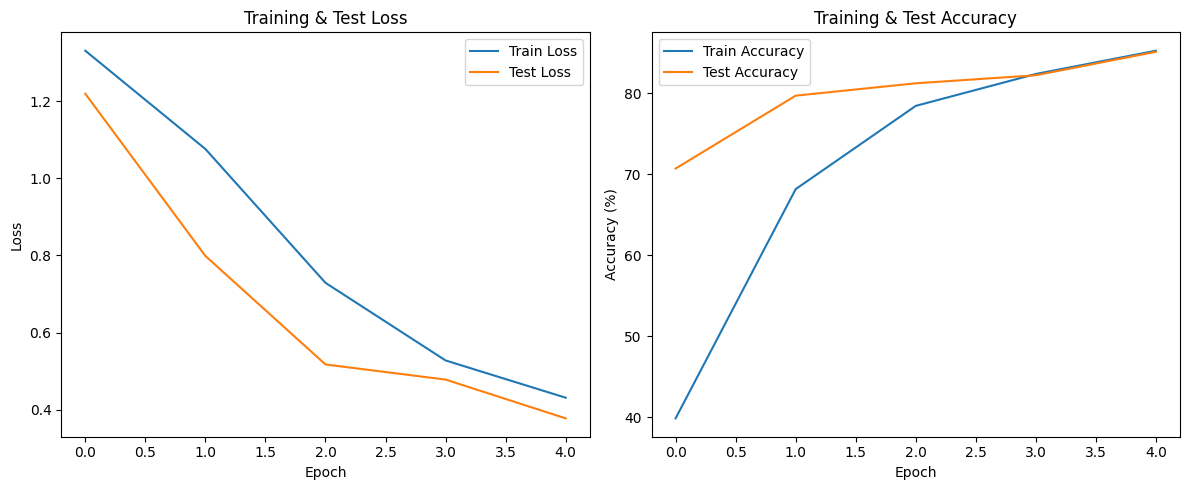

In [11]:
# plot Losses and Accuracies history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# --- Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Training & Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

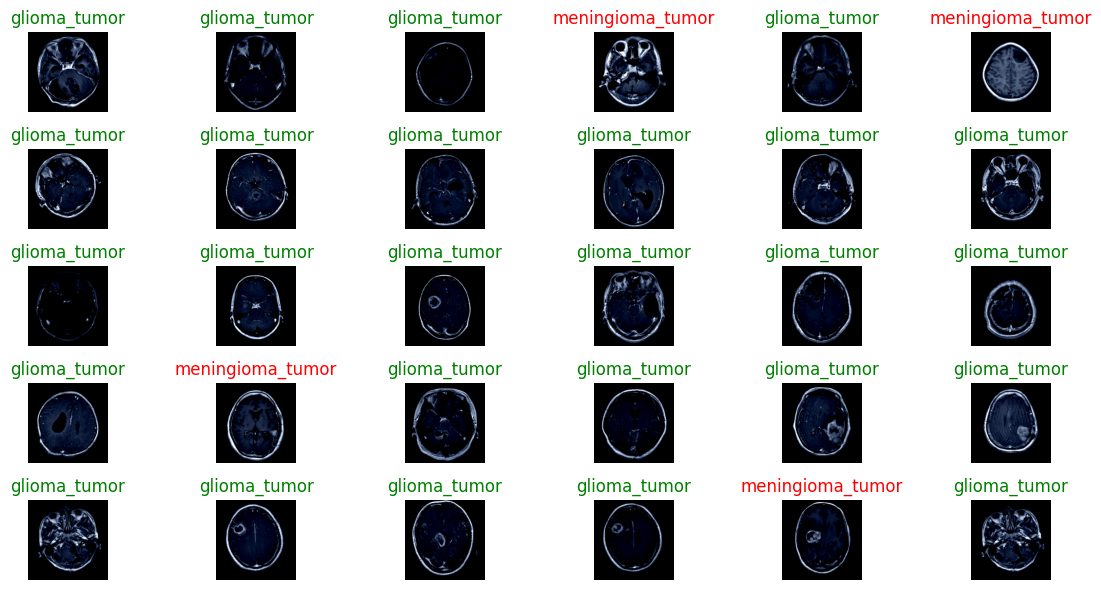

In [12]:
import numpy as np
# visualisation des prédictions

def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get predictions
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)


# Plot images and predictions

fig = plt.figure(figsize=(12, 6))
for i in range(30):
  ax = fig.add_subplot(5, 6, i+1, xticks=[], yticks=[])
  imshow(images[i])
  ax.set_title(f"{test_dataset.classes[predicted[i]]}", color=("green" if predicted[i] == labels[i] else "red"))

plt.tight_layout()
plt.show()